In [2]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import pingouin as pg
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *
palette_tab10 = sns.color_palette("tab10", 10)

In [3]:
# Load accuracies
accuracies = pd.read_csv('accuracies.csv')

In [4]:
# Load ERPs
evokeds = pd.read_csv('evokeds.csv')
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,1,1,high,-173,-8.727872e-08
1,10,Cz,True,1,1,high,-172,-9.012204e-08
2,10,Cz,True,1,1,high,-171,-1.052924e-07
3,10,Cz,True,1,1,high,-170,-1.171627e-07
4,10,Cz,True,1,1,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,3,3,high,522,5.592560e-07
1984496,41,Pz,False,3,3,high,523,5.489198e-07
1984497,41,Pz,False,3,3,high,524,5.435890e-07
1984498,41,Pz,False,3,3,high,525,5.367600e-07


In [5]:
# Rename target and tone vars to freq
mapping = {1: 110,
           2: 150,
           3: 210}

evokeds['target'] = evokeds['target'].replace(mapping)
evokeds['tone'] = evokeds['tone'].replace(mapping)
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-8.727872e-08
1,10,Cz,True,110,110,high,-172,-9.012204e-08
2,10,Cz,True,110,110,high,-171,-1.052924e-07
3,10,Cz,True,110,110,high,-170,-1.171627e-07
4,10,Cz,True,110,110,high,-169,-1.369268e-07
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,5.592560e-07
1984496,41,Pz,False,210,210,high,523,5.489198e-07
1984497,41,Pz,False,210,210,high,524,5.435890e-07
1984498,41,Pz,False,210,210,high,525,5.367600e-07


In [6]:
# Adjust EEG units
evokeds['uV'] = evokeds['uV'] * 1000000 - 0.30
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,10,Cz,True,110,110,high,-173,-0.387279
1,10,Cz,True,110,110,high,-172,-0.390122
2,10,Cz,True,110,110,high,-171,-0.405292
3,10,Cz,True,110,110,high,-170,-0.417163
4,10,Cz,True,110,110,high,-169,-0.436927
...,...,...,...,...,...,...,...,...
1984495,41,Pz,False,210,210,high,522,0.259256
1984496,41,Pz,False,210,210,high,523,0.248920
1984497,41,Pz,False,210,210,high,524,0.243589
1984498,41,Pz,False,210,210,high,525,0.236760


In [7]:
# Adjust EEG timing according to lag
evokeds['msec'] = evokeds['msec'] - 27

In [8]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    evokeds = evokeds[evokeds['sub'] != bad]
np.unique(evokeds['sub'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [9]:
# Split data up for analyses
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_tone_1 = evokeds_Cz[evokeds_Cz.tone == 110]
evokeds_tone_2 = evokeds_Cz[evokeds_Cz.tone == 150]
evokeds_tone_3 = evokeds_Cz[evokeds_Cz.tone == 210]

# Tests on mean amplitudes

#### N1 (mean value from 100-150 msec)

In [15]:
seg = evokeds_Cz[evokeds_Cz.msec > 100]
seg = seg[seg.msec < 150]

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone        15.8942 2.0000  58.0000 0.0000
target       0.3972 2.0000  58.0000 0.6740
tone:target  4.4272 4.0000 116.0000 0.0023



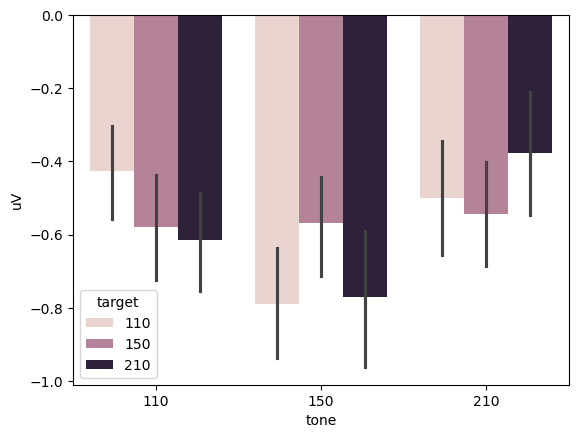

In [36]:
# By target
seg_target = seg.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="target")
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
accuracy     0.785      1     28  0.785   2.473    0.127  0.081  nan
tone         0.877      2     56  0.439  15.651    0.000  0.359    0.989
Interaction  0.031      2     56  0.016   0.557    0.576  0.019  nan



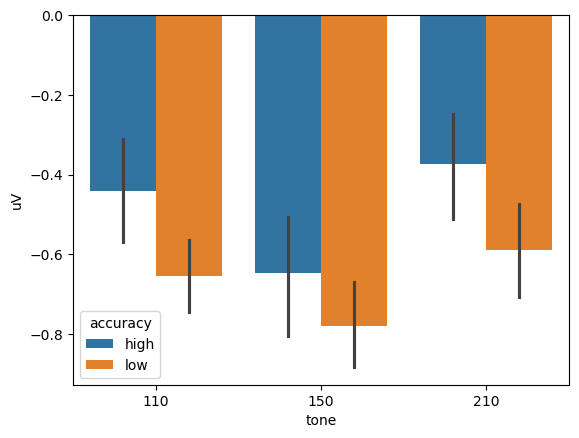

In [35]:
# By target and accuracy
seg_accuracy = seg.groupby(['sub', 'tone', 'target', 'accuracy'], as_index=False)['uV'].mean()
sns.barplot(seg_accuracy, x="tone", y="uV", hue="accuracy")
aov = seg_accuracy.mixed_anova(dv='uV', within='tone', between='accuracy', subject='sub')
pg.print_table(aov)

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
tone                    15.8942 2.0000  58.0000 0.0000
target                   0.3972 2.0000  58.0000 0.6740
predictable             46.1636 1.0000  29.0000 0.0000
tone:target              4.4272 4.0000 116.0000 0.0023
tone:predictable         6.9412 2.0000  58.0000 0.0020
target:predictable       0.7922 2.0000  58.0000 0.4577
tone:target:predictable  0.3057 4.0000 116.0000 0.8737



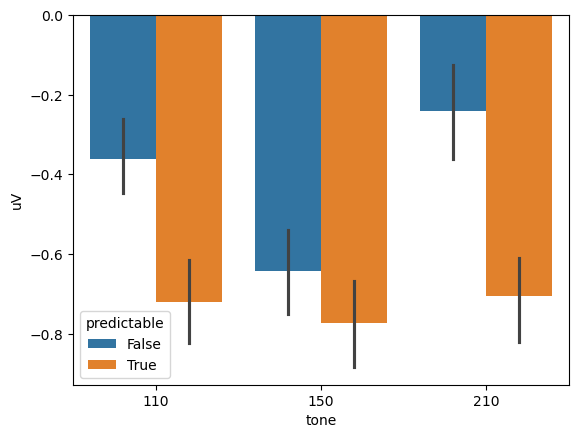

In [34]:
# By target and predictability
seg_predictable = seg.groupby(['sub', 'tone', 'target', 'predictable'], as_index=False)['uV'].mean()
sns.barplot(seg_predictable, x="tone", y="uV", hue="predictable")
aov = AnovaRM(
    data = seg_predictable, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target', 'predictable']
)
res = aov.fit()
print(res)

#### N2 (mean value from 250-360 msec)

In [14]:
seg = evokeds_Cz[evokeds_Cz.msec > 270]
seg = seg[seg.msec < 360]

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone        13.0992 2.0000  58.0000 0.0000
target       0.6149 2.0000  58.0000 0.5442
tone:target  6.2184 4.0000 116.0000 0.0001



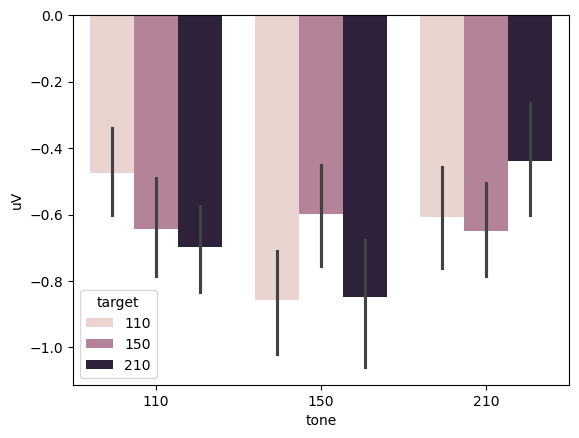

In [15]:
# By target
seg_target = seg.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="target")
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
accuracy     0.799      1     28  0.799   2.407    0.132  0.079  nan
tone         0.691      2     56  0.346  13.077    0.000  0.318    0.999
Interaction  0.050      2     56  0.025   0.951    0.393  0.033  nan



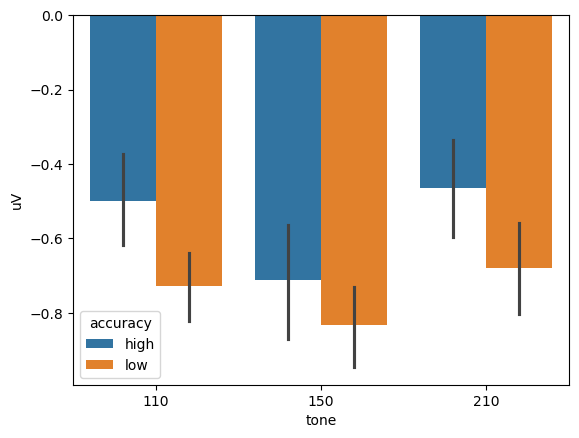

In [16]:
# By target and accuracy
seg_accuracy = seg.groupby(['sub', 'tone', 'target', 'accuracy'], as_index=False)['uV'].mean()
sns.barplot(seg_accuracy, x="tone", y="uV", hue="accuracy")
aov = seg_accuracy.mixed_anova(dv='uV', within='tone', between='accuracy', subject='sub')
pg.print_table(aov)

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
tone                    13.0992 2.0000  58.0000 0.0000
target                   0.6149 2.0000  58.0000 0.5442
predictable             47.2820 1.0000  29.0000 0.0000
tone:target              6.2184 4.0000 116.0000 0.0001
tone:predictable         6.4439 2.0000  58.0000 0.0030
target:predictable       0.8103 2.0000  58.0000 0.4497
tone:target:predictable  0.2590 4.0000 116.0000 0.9037



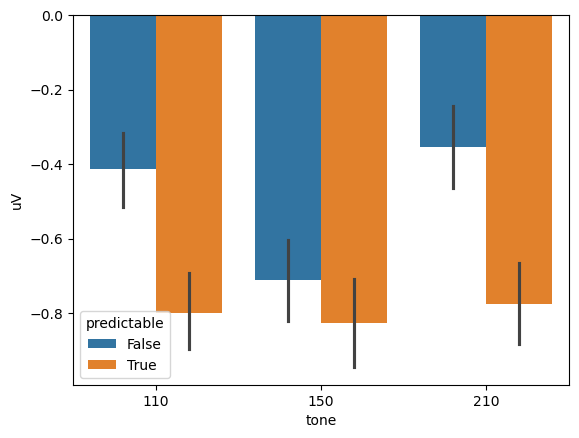

In [17]:
# By target and predictability
seg_predictable = seg.groupby(['sub', 'tone', 'target', 'predictable'], as_index=False)['uV'].mean()
sns.barplot(seg_predictable, x="tone", y="uV", hue="predictable")
aov = AnovaRM(
    data = seg_predictable, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target', 'predictable']
)
res = aov.fit()
print(res)

#### P4 (mean value from 360-420 msec)

In [22]:
seg = evokeds_Cz[evokeds_Cz.msec > 360]
seg = seg[seg.msec < 430]

                  Anova
            F Value Num DF  Den DF  Pr > F
------------------------------------------
tone         4.1415 2.0000  58.0000 0.0208
target       0.7798 2.0000  58.0000 0.4632
tone:target  9.8957 4.0000 116.0000 0.0000



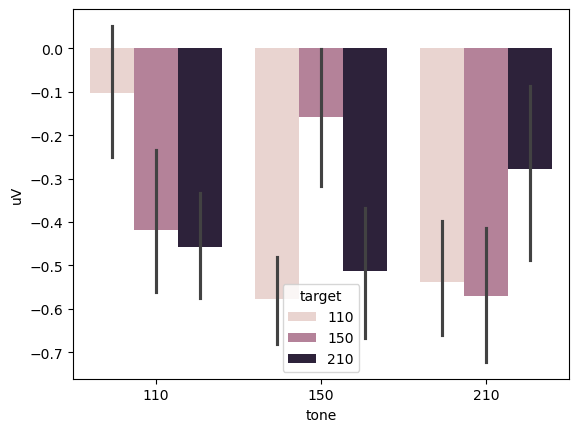

In [24]:
# By target
seg_target = seg.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
sns.barplot(seg_target, x="tone", y="uV", hue="target")
aov = AnovaRM(
    data = seg_target, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target']
)
res = aov.fit()
print(res)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
accuracy     0.274      1     28  0.274  1.145    0.294  0.039  nan
tone         0.288      2     56  0.144  4.093    0.022  0.128    0.982
Interaction  0.047      2     56  0.023  0.663    0.519  0.023  nan



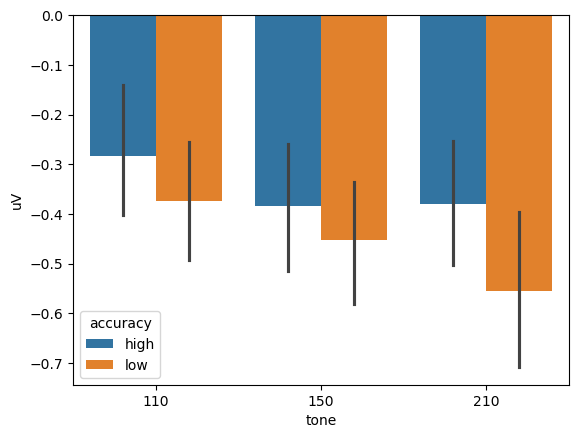

In [25]:
# By target and accuracy
seg_accuracy = seg.groupby(['sub', 'tone', 'target', 'accuracy'], as_index=False)['uV'].mean()
sns.barplot(seg_accuracy, x="tone", y="uV", hue="accuracy")
aov = seg_accuracy.mixed_anova(dv='uV', within='tone', between='accuracy', subject='sub')
pg.print_table(aov)

                        Anova
                        F Value Num DF  Den DF  Pr > F
------------------------------------------------------
tone                     4.1415 2.0000  58.0000 0.0208
target                   0.7798 2.0000  58.0000 0.4632
predictable              0.8881 1.0000  29.0000 0.3538
tone:target              9.8957 4.0000 116.0000 0.0000
tone:predictable         3.3196 2.0000  58.0000 0.0432
target:predictable       1.6579 2.0000  58.0000 0.1994
tone:target:predictable  1.6127 4.0000 116.0000 0.1757



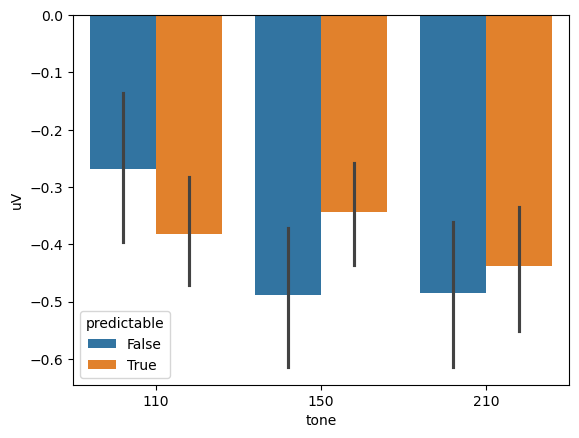

In [26]:
# By target and predictability
seg_predictable = seg.groupby(['sub', 'tone', 'target', 'predictable'], as_index=False)['uV'].mean()
sns.barplot(seg_predictable, x="tone", y="uV", hue="predictable")
aov = AnovaRM(
    data = seg_predictable, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['tone', 'target', 'predictable']
)
res = aov.fit()
print(res)

# Latencies

In [ ]:
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds_tone = mean_evokeds.groupby(['chan', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['chan', 'target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target

#### Min at 100-180 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 100]
seg_tone = seg_tone[seg_tone.msec < 180]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 100]
seg_target = seg_target[seg_target.msec < 180]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Max at 150-280 msec

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 150]
seg_tone = seg_tone[seg_tone.msec < 280]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 150]
seg_target = seg_target[seg_target.msec < 280]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == max(tmp.uV)])
print(f'Latency of max tone 3, target 3: {lat}')

#### Min at 250-450 msec (important)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 250]
seg_tone = seg_tone[seg_tone.msec < 450]

# # Tone 1
tmp = seg_tone[(seg_tone.tone == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1: {lat}')
# # Tone 2
tmp = seg_tone[(seg_tone.tone == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2: {lat}')
# # Tone 3
tmp = seg_tone[(seg_tone.tone == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3: {lat}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 250]
seg_target = seg_target[seg_target.msec < 450]

# Tone 1 when tone 1 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 1: {lat}')
# Tone 1 when tone 2 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 2: {lat}')
# Tone 1 when tone 3 is target
tmp = seg_target[(seg_target.tone == 110) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 1, target 3: {lat}')

# Tone 2 when tone 1 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 1: {lat}')
# Tone 2 when tone 2 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 2: {lat}')
# Tone 2 when tone 3 is target
tmp = seg_target[(seg_target.tone == 150) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 2, target 3: {lat}')

# Tone 3 when tone 1 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 110)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 1: {lat}')
# Tone 3 when tone 2 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 150)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 2: {lat}')
# Tone 3 when tone 3 is target
tmp = seg_target[(seg_target.tone == 210) & (seg_target.target == 210)]
lat = int(tmp.msec[tmp.uV == min(tmp.uV)])
print(f'Latency of min tone 3, target 3: {lat}')

#### Tests on latencies

In [ ]:
evokeds

In [ ]:
predictability = [True, False]

def get_latencies_tone(evokeds, start, end, peak_type):
    all_lat = []
    tones = [110, 150, 210]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            evokeds_cz = evokeds[evokeds.chan == 'Cz']
            evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
            seg = evokeds_sub[evokeds_sub.msec > start]
            seg = seg[seg.msec < end]
            seg = seg[seg.tone == tone]
            if peak_type == 'min':
                peak = min(seg.uV)
            elif peak_type == 'max':
                peak = max(seg.uV)
            lat = int(seg.msec[seg.uV == peak])
            df = pd.DataFrame({
                'sub': [sub],
                'start': [start],
                'end': [end],
                'tone': [tone],
                'peak_type': [peak_type],
                'peak': [peak],
                'latency': [lat],
            })
            all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat
    
def get_latencies_target(evokeds, start, end, peak_type):
    all_lat = []
    tones = [110, 150, 210]
    for sub in np.unique(evokeds['sub']):
        for tone in tones:
            for target in tones:
                evokeds_cz = evokeds[evokeds.chan == 'Cz']
                evokeds_sub = evokeds_cz[evokeds_cz['sub'] == sub]
                seg = evokeds_sub[evokeds_sub.msec > start]
                seg = seg[seg.msec < end]
                seg = seg[(seg.tone == tone) & (seg.target == target)]
                if peak_type == 'min':
                    peak = min(seg.uV)
                elif peak_type == 'max':
                    peak = max(seg.uV)
                lat = int(seg.msec[seg.uV == peak])
                df = pd.DataFrame({
                    'sub': [sub],
                    'start': [start],
                    'end': [end],
                    'tone': [tone],
                    'target': [target],
                    'peak_type': [peak_type],
                    'peak': [peak],
                    'latency': [lat],
                })
                all_lat.append(df)
    all_lat = pd.concat(all_lat)
    return all_lat

#### Min at 100-180 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 100, 180, 'min')
latencies_target = get_latencies_target(evokeds, 100, 180, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Max at 150-280 msec

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 150, 280, 'max')
latencies_target = get_latencies_target(evokeds, 150, 280, 'max')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

#### Min at 250-450 msec (important)

In [ ]:
latencies_tone = get_latencies_tone(evokeds, 250, 450, 'min')
latencies_target = get_latencies_target(evokeds, 250, 450, 'min')

In [ ]:
sns.barplot(latencies_tone, x = "tone", y = "latency")

In [ ]:
sns.barplot(latencies_target, x = "tone", y = "latency", hue = "target")

# Predictability

### Peaks

In [ ]:
mean_evokeds_predictable = mean_evokeds.groupby(['sub', 'tone', 'predictable', 'msec'], as_index=False)['uV'].mean()

#### Max at 80-130 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 80]
seg = seg[seg.msec < 130]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 100-180 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 100]
seg = seg[seg.msec < 180]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Max at 150-280 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 150]
seg = seg[seg.msec < 280]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

#### Min at 250-450 msec

In [ ]:
seg = mean_evokeds_predictable[mean_evokeds_predictable.msec > 250]
seg = seg[seg.msec < 450]

# Tone 1
seg_1 = seg[seg.tone == 110]
print(f'Max for predictable tone 1: {max(seg_1.uV[seg_1.predictable == True])}')
print(f'Max for unpredictable tone 1: {max(seg_1.uV[seg_1.predictable == False])}')

# Tone 2
seg_2 = seg[seg.tone == 150]
print(f'Max for predictable tone 2: {max(seg_2.uV[seg_2.predictable == True])}')
print(f'Max for unpredictable tone 2: {max(seg_2.uV[seg_2.predictable == False])}')

# Tone 3
seg_3 = seg[seg.tone == 210]
print(f'Max for predictable tone 3: {max(seg_3.uV[seg_3.predictable == True])}')
print(f'Max for unpredictable tone 3: {max(seg_3.uV[seg_3.predictable == False])}')

# Plot
seg = seg.groupby(['sub', 'tone', 'predictable'], as_index = False)['uV'].max()
sns.barplot(seg, x = "tone", y = "uV", hue = "predictable")

# Test
aov = AnovaRM(
    data = seg, 
    depvar = 'uV',
    subject = 'sub', 
    within = ['predictable', 'tone']
)
res = aov.fit()
print(res)

# Peak values

In [17]:
mean_evokeds_tone = evokeds_Cz.groupby(['tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_target = mean_evokeds.groupby(['target', 'tone', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable = mean_evokeds.groupby(['tone', 'predictable', 'msec'], as_index=False)['uV'].mean()
mean_evokeds_predictable

,tone,predictable,msec,uV
0,110,False,-200,-0.626845
1,110,False,-199,-0.625476
2,110,False,-198,-0.631240
3,110,False,-197,-0.631118
4,110,False,-196,-0.636858
...,...,...,...,...
4195,210,True,495,0.087812
4196,210,True,496,0.086111
4197,210,True,497,0.090669
4198,210,True,498,0.088699


#### P1 (max at 50-100 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 50]
seg_tone = seg_tone[seg_tone.msec < 100]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 50]
seg_target = seg_target[seg_target.msec < 100]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### N1 (min at 70-150 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 70]
seg_tone = seg_tone[seg_tone.msec < 150]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 70]
seg_target = seg_target[seg_target.msec < 150]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### P2 (max at 120-250 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 120]
seg_tone = seg_tone[seg_tone.msec < 250]

# Tone 1
print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 120]
seg_target = seg_target[seg_target.msec < 250]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {max(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {max(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')

#### N2 (min at 220-420 msec)

In [ ]:
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 220]
seg_tone = seg_tone[seg_tone.msec < 420]

# Tone 1
print(f'Max tone 1: {min(seg_tone.uV[seg_tone.tone == 110])}')
# Tone 2
print(f'Max tone 2: {min(seg_tone.uV[seg_tone.tone == 150])}')
# Tone 3
print(f'Max tone 3: {min(seg_tone.uV[seg_tone.tone == 210])}')

seg_target = mean_evokeds_target[mean_evokeds_target.msec > 220]
seg_target = seg_target[seg_target.msec < 420]

# Tone 1 when tone 1 is target
print(f'Max tone 1, target 1: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 110)])}')
# Tone 1 when tone 2 is target
print(f'Max tone 1, target 2: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 150)])}')
# Tone 1 when tone 3 is target
print(f'Max tone 1, target 3: {min(seg_target.uV[(seg_target.tone == 110) & (seg_target.target == 210)])}')
# Tone 2 when tone 1 is target
print(f'Max tone 2, target 1: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 110)])}')
# Tone 2 when tone 2 is target
print(f'Max tone 2, target 2: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 150)])}')
# Tone 2 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 150) & (seg_target.target == 210)])}')
# Tone 3 when tone 1 is target
print(f'Max tone 3, target 1: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 110)])}')
# Tone 3 when tone 2 is target
print(f'Max tone 3, target 2: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 150)])}')
# Tone 3 when tone 3 is target
print(f'Max tone 3, target 3: {min(seg_target.uV[(seg_target.tone == 210) & (seg_target.target == 210)])}')